Look at transcript selections from ORFquant (previously satann)

In [1]:
import pandas as pd
import numpy as np
import math
import sys
sys.path.append('../ribo_seq/')
import ribo_utils

### Import transcript info

In [2]:
comprehensive_gtf_data = ribo_utils.gtf_data('../annotations/gencode.v35.annotation.pBZ105.no_nonstop.gtf', add_3_for_stop = True, store_lines=True)

In [3]:
#get list of all tx in annotations
all_tx = comprehensive_gtf_data.transcript_to_entries.keys()
len(all_tx)

80675

In [28]:
#get transcripts output by ORFquant
import os
orfquant_tx_files = [file_name for file_name in os.listdir('.') if file_name.endswith('.selected_tx.txt') and not file_name.startswith('.')]
sample_names = [file_name[:-27] for file_name in orfquant_tx_files]
print sample_names
orfquant_tx_file_paths = [file_name for file_name in orfquant_tx_files]

def tx_from_file(file_name):
    txs = []
    f = open(file_name)
    for line in f:
        txs.append(line.strip())
    f.close()
    return set(txs)

sample_to_tx = {}
for i in range(len(orfquant_tx_file_paths)):
    sample_to_tx[sample_names[i]] = tx_from_file(orfquant_tx_file_paths[i])

['mono']


In [29]:
sample_tx_histograms = {}
for dataset in sample_to_tx.keys():
    sample_tx_histograms[dataset] = comprehensive_gtf_data.get_transcript_multiplicity(gene_type=None, transcript_subset=sample_to_tx[dataset])

In [30]:
sample_tx_histograms['all'] = comprehensive_gtf_data.get_transcript_multiplicity()

In [31]:
sample_tx_histograms.keys()

['mono', 'all']

In [32]:
import numpy
def hist_to_step(histogram, exclude=[], normalize = False):
    #x=[]
    x = [num_tx for num_tx in sorted(histogram.keys()) if num_tx not in exclude]
    y = [histogram[num_tx] for num_tx in x]
    if normalize:
        y = numpy.array(y)/float(sum(y))
    return x, list(y)

In [33]:
#set up plotting
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
plt.rcParams['pdf.fonttype'] = 42 #leaves most text as actual text in PDFs, not outlines
# Say, "the default sans-serif font is arial"
mpl.rcParams['font.sans-serif'] = "Arial"
# Then, "ALWAYS use sans-serif fonts"
mpl.rcParams['font.family'] = "sans-serif"
#colorblind safe colors
black = (0,0,0)
gray = (0.5,0.5,0.5)
orange = (230/255.0,159/255.0,0)
skyBlue = (86/255.0,180/255.0,233/255.0)
bluishGreen = (0,158/255.0,115/255.0)
yellow = (240/255.0,228/255.0,66/255.0)
blue = (0,114/255.0,178/255.0)
vermillion = (213/255.0,94/255.0,0)
reddishPurple = (204/255.0,121/255.0,167/255.0)
colors = [gray, black, blue, orange, bluishGreen, skyBlue, vermillion, reddishPurple, yellow, 'red', 'green']
rainbow = [black, vermillion, orange, bluishGreen, blue, reddishPurple, 'violet']

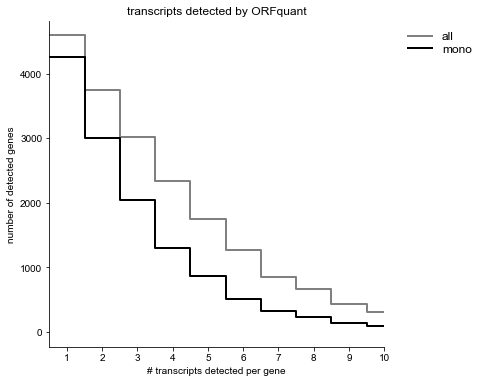

In [34]:
#histograms of transcript numbers
#with and w/o zeros

plot_index = 1
num_plots_wide = 1
num_plots_high = 1

fig = plt.figure(figsize=(6*num_plots_wide, 6*num_plots_high))
plot = fig.add_subplot(num_plots_high, num_plots_wide, plot_index)
color_index = 0
for dataset in sorted(sample_tx_histograms.keys()):
        #if dataset not in ["all"]:
            x, y = hist_to_step(sample_tx_histograms[dataset], exclude=[0], normalize=False)
            plot.step([0.5]+x, [y[0]]+y, color=colors[color_index], label='%s' %(dataset), lw=2, where='mid')
            color_index += 1

            plot.set_xlabel("# transcripts detected per gene")
            plot.set_ylabel("number of detected genes")
            plot.set_title('transcripts detected by ORFquant')

            plot.spines['right'].set_visible(False)
            plot.spines['top'].set_visible(False)
            plot.set_xticks(range(11))
            #plot.set_ylim(0, 1)
            plot.set_xlim(0.5, 10)
            plot_index += 1
            lg=plt.legend(prop={'size':12}, labelspacing=0.2, bbox_to_anchor=(1.04,1), loc="upper left")
            lg.draw_frame(False)
#plt.tight_layout()
plt.savefig('transcripts_per_gene_orfquant.pdf', transparent='True', format='pdf')

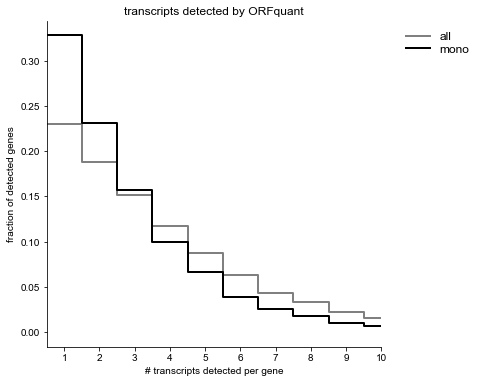

In [35]:
#histograms of transcript numbers
#with and w/o zeros

plot_index = 1
num_plots_wide = 1
num_plots_high = 1

fig = plt.figure(figsize=(6*num_plots_wide, 6*num_plots_high))
plot = fig.add_subplot(num_plots_high, num_plots_wide, plot_index)
color_index = 0
for dataset in sorted(sample_tx_histograms.keys()):
        #if dataset not in ["all"]:
            x, y = hist_to_step(sample_tx_histograms[dataset], exclude=[0], normalize=True)
            plot.step([0.5]+x, [y[0]]+y, color=colors[color_index], label='%s' %(dataset), lw=2, where='mid')
            color_index += 1

            plot.set_xlabel("# transcripts detected per gene")
            plot.set_ylabel("fraction of detected genes")
            plot.set_title('transcripts detected by ORFquant')

            plot.spines['right'].set_visible(False)
            plot.spines['top'].set_visible(False)
            plot.set_xticks(range(11))
            #plot.set_ylim(0, 1)
            plot.set_xlim(0.5, 10)
            plot_index += 1
            lg=plt.legend(prop={'size':12}, labelspacing=0.2, bbox_to_anchor=(1.04,1), loc="upper left")
            lg.draw_frame(False)
#plt.tight_layout()
plt.savefig('frac_transcripts_per_gene_orfquant.pdf', transparent='True', format='pdf')

In [36]:
for sample in sample_to_tx.keys():
    print(sample, len(sample_to_tx[sample]))

('mono', 38389)


In [37]:
def get_genomic_stop_coords(x):
    stop_entry = comprehensive_gtf_data.sorted_exons(x, exon_type='stop_codon')
    if len(stop_entry) == 0:
        return 'not annotated'
    stop = '%s %s %s %s' % (stop_entry[0].get_value('chr'), stop_entry[0].get_value('strand'), 
                             stop_entry[0].get_value('start'), stop_entry[0].get_value('end'))
    return stop

## output gene sets to file

In [38]:
comprehensive_gtf_data.write_transcript_entries_to_file(os.path.join('orfquant_chosen_tx.gtf'), transcript_ids=sample_to_tx['mono'])

## generate annotation with all tx with same stop combined

In [39]:
def get_genomic_stop_coords(x):
    #if given a |-seperated list of tx, will only return value for first one
    if '|' in x:
        return get_genomic_stop_coords(x.split('|')[0])
    stop_entry = comprehensive_gtf_data.sorted_exons(x, exon_type='stop_codon')
    if len(stop_entry) == 0:
        return 'not annotated'
    stop = '%s %s %s %s' % (stop_entry[0].get_value('chr'), stop_entry[0].get_value('strand'), 
                             stop_entry[0].get_value('start'), stop_entry[0].get_value('end'))
    return stop

In [40]:
#take superset transcript set, combine all transcripts with same stop codon, and make new set files
#first, make nested dict grouping transcripts first by gene then by stop
from collections import defaultdict
tx_by_stop = defaultdict(lambda: defaultdict(list))
for transcript in sample_to_tx['mono']:
    parent_gene = comprehensive_gtf_data.tx_to_genes[transcript]
    stop_codon = get_genomic_stop_coords(transcript)
    tx_by_stop[parent_gene][stop_codon].append(transcript)

In [42]:
stops_collapsed = []
for gene in tx_by_stop:
    for stop in tx_by_stop[gene]:
        transcripts = tx_by_stop[gene][stop]
        longest_cds_tx = transcripts[0]
        for transcript in transcripts[1:]:
            if comprehensive_gtf_data.spliced_length(transcript, exon_type=['CDS', 'stop_codon']) > comprehensive_gtf_data.spliced_length(longest_cds_tx, exon_type=['CDS', 'stop_codon']):
                longest_cds_tx = transcript
            elif comprehensive_gtf_data.spliced_length(transcript, exon_type=['CDS', 'stop_codon']) == comprehensive_gtf_data.spliced_length(longest_cds_tx, exon_type=['CDS', 'stop_codon']):
                if comprehensive_gtf_data.spliced_length(transcript, exon_type=['exon']) > comprehensive_gtf_data.spliced_length(longest_cds_tx, exon_type=['exon']):
                    longest_cds_tx = transcript
                elif comprehensive_gtf_data.spliced_length(transcript, exon_type=['exon']) == comprehensive_gtf_data.spliced_length(longest_cds_tx, exon_type=['exon']):
                    print transcripts
                    print "double tie", gene, stop, longest_cds_tx, transcript
        stops_collapsed.append(longest_cds_tx)

['ENST00000395123.6', 'ENST00000529554.5', 'ENST00000395124.6', 'ENST00000533524.5']
double tie ENSG00000134802.18 chr11 - 57407792 57407794 ENST00000395123.6 ENST00000395124.6
['ENST00000496817.5', 'ENST00000368719.9', 'ENST00000368720.6']
double tie ENSG00000197956.10 chr1 - 153534696 153534698 ENST00000496817.5 ENST00000368720.6
['ENST00000494992.5', 'ENST00000605679.5', 'ENST00000483386.5']
double tie ENSG00000176273.15 chr10 + 93906263 93906265 ENST00000494992.5 ENST00000605679.5
['ENST00000583522.5', 'ENST00000577682.5', 'ENST00000581381.5', 'ENST00000582266.5', 'ENST00000583953.5']
double tie ENSG00000173065.13 chr17 - 28759760 28759762 ENST00000583522.5 ENST00000581381.5
['ENST00000360243.6', 'ENST00000393920.5', 'ENST00000276344.6', 'ENST00000370340.7', 'ENST00000370335.5', 'ENST00000393921.5']
double tie ENSG00000147381.11 chrX + 151924616 151924618 ENST00000360243.6 ENST00000370340.7
['ENST00000360243.6', 'ENST00000393920.5', 'ENST00000276344.6', 'ENST00000370340.7', 'ENST00

In [44]:
print len(stops_collapsed)

24337


In [45]:
def write_tx_to_file(tx_set, file_name):
    f = open(file_name, 'w')
    for tx_id in tx_set:
        f.write('%s\n' % tx_id)
    f.close()


In [47]:
write_tx_to_file(stops_collapsed, os.path.join('orfquant_tx_stops_collapsed.txt'))

In [48]:
comprehensive_gtf_data.write_transcript_entries_to_file(os.path.join('../annotations/orfquant_stops_collapsed.gtf'), transcript_ids=stops_collapsed)